In [4]:
from fontlib import Rect, Char
from PIL import Image, ImageFont
import cv2

## 1. Генерация изображения

rect: {x0: 28, y0: 27, x1: 61, y1: 27, x2: 28, y2: 90, x3: 61, y3: 90}


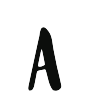

In [122]:
# без текстуры
font = ImageFont.truetype("fonts/Stay Wildy.ttf", 100)
char = Char.from_font(char="A", 
                      font=font, 
                      font_color=(12, 14, 12), 
                      image_size=(100, 100))
print("rect: %s" % char.rect)
char.image

rect: {x0: 28, y0: 27, x1: 61, y1: 27, x2: 28, y2: 90, x3: 61, y3: 90}


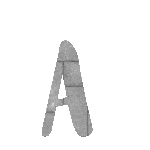

In [124]:
# с текстурой
font = ImageFont.truetype("fonts/Stay Wildy.ttf", 150)
with Image.open("font_texture.jpg") as texture:
    char_texture = Char.from_font(char="A", 
                          font=font, 
                          font_texture=texture,
                          image_size=(150, 150))
                            
print("rect: %s" % char.rect)
char_texture.image

## 2. Гомография

rect: {x0: 28, y0: 27, x1: 61, y1: 27, x2: 28, y2: 90, x3: 61, y3: 90}


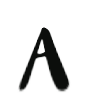

In [126]:
rect = Rect(char.rect.x0 + 5, char.rect.y0,
            char.rect.x1 - 5, char.rect.y1,
            char.rect.x2 - 10, char.rect.y2,
            char.rect.x3 + 10, char.rect.y3)
char_hm = char.apply_homography(rect)
print("rect: %s" % char.rect)
char_hm.image

## 3. Размытие

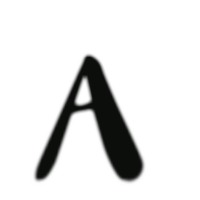

In [119]:
kernel = (5, 5)
char_blurred = char_hm.blur(kernel)
char_blurred.image

## 4. Наложение фона

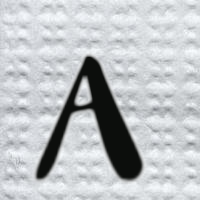

In [121]:
with Image.open("pattern.jpg") as bg_img:
    char_with_bg = char_blurred.add_background(bg_img)
char_with_bg.image